0.23570226039551587
[-0.70710678-0.70710678j -0.70710678-0.23570226j -0.70710678+0.23570226j
 -0.70710678+0.70710678j -0.23570226-0.70710678j -0.23570226-0.23570226j
 -0.23570226+0.23570226j -0.23570226+0.70710678j  0.23570226-0.70710678j
  0.23570226-0.23570226j  0.23570226+0.23570226j  0.23570226+0.70710678j
  0.70710678-0.70710678j  0.70710678-0.23570226j  0.70710678+0.23570226j
  0.70710678+0.70710678j]
[-91. -91. -91. -91. -31. -31. -31. -31.  30.  30.  30.  30.  90.  90.
  90.  90.]


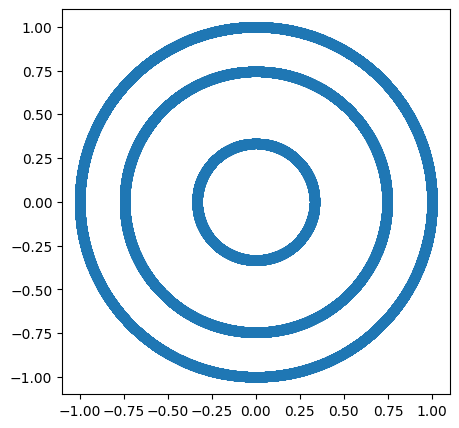

In [7]:
# SIMULACION ALTO NIVEL FCR
#   simulacion de la recuperacion de la portadora pero usando aproximacion de atan por medio de polinomios
#   coeficientes sacados de atan.ipinb
#       Valores usados en el archivo:
#               NBF         = 7     Bits fraccionales dato de entrada
#               NBF_COEFF   = 31    Bits fraccionales coefficiente
#               
#
#

import numpy as np
import matplotlib.pyplot as plt
import math

qam16_constellation = {
    0: (-3, -3), 1: (-3, -1), 2: (-3, 1), 3: (-3, 3),
    4: (-1, -3), 5: (-1, -1), 6: (-1, 1), 7: (-1, 3),
    8: (1, -3), 9: (1, -1), 10: (1, 1), 11: (1, 3),
    12: (3, -3), 13: (3, -1), 14: (3, 1), 15: (3, 3)
}

k = np.real( complex(1,0) * np.exp(1j*np.deg2rad(45)) ) / 3

print(k)

qam16_constellation = {key: (k * I, k * Q) for key, (I, Q) in qam16_constellation.items()}

symbols=np.array([complex(i,q) for i,q in qam16_constellation.values()])
print(symbols)
print(np.floor(symbols.real*(2**7)))

n_samples=100000

indices = np.random.randint(0, len(symbols), n_samples)
tx_symbols = symbols[indices]

freq_offset = 80*np.pi/180

n = np.arange(n_samples)
rx_symbols = tx_symbols * np.exp(1j * 2 * np.pi * freq_offset * n)

plt.figure(figsize=(5,5))
plt.scatter(np.real(rx_symbols), np.imag(rx_symbols))

Damping Ratio (ζ): 1.118033988749895
Overdamped (Slow Response): ζ>1


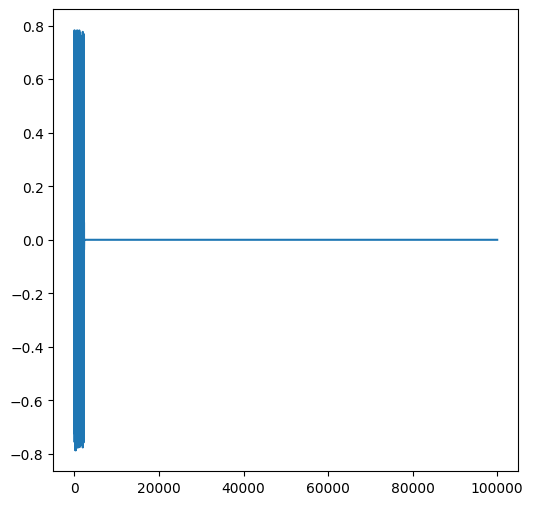

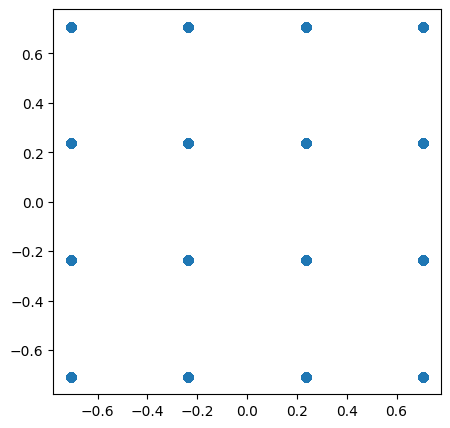

In [8]:
recovered_symbols = np.zeros(n_samples, dtype=complex)

Kp = 0.5  
Ki = 0.05 
zeta = Kp / (2 * np.sqrt(Ki))

print(f"Damping Ratio (ζ): {zeta}")
if(zeta < 1):
        print("Underdamped (Oscillatory Response): ζ<1")
elif (zeta == 1):
        print("Critically Damped (Fastest No-Overshoot Response): ζ=1")
else:
        print("Overdamped (Slow Response): ζ>1")

phase_nco = 0  
freq_nco = 0   
integrator = 0  
phase_errors = np.zeros(n_samples)

coeff_0_5   = np.array([ 0.00000000e+00,  1.08663477e+00, -2.79863347e-01, -8.26001880e-02,  8.05663681e-02, -2.37380471e-02,  3.23200598e-03, -1.71658583e-04])
coeff_5_25  = np.array([ 1.05131423e+00,  1.05555524e-01, -1.07802572e-02,  5.87491319e-04, -1.62972137e-05,  1.80676579e-07                                  ])
coeff_25_127= np.array([ 1.49527825e+00,  1.82146719e-03, -1.74287707e-05,  5.72763383e-08                                                                     ])

for i in range(n_samples):
        corrected_symbol = rx_symbols[i] * np.exp(-1j * phase_nco)

        closest_symbol = symbols[np.argmin(abs(symbols - corrected_symbol))]
        # phase_error = np.angle(corrected_symbol * np.conj(closest_symbol)) i have to modify this line
        # symbol_phase_error = corrected_symbol * np.conj(closest_symbol) # here i have s(n)*e^(j(offset))
        # print(corrected_symbol)

        # DIVISION CORRECTED SYMBOL
        if np.imag(corrected_symbol) == 0:
                q_i_div_cs=0
        else:
                q_i_div_cs = np.abs(np.imag(corrected_symbol)/np.real(corrected_symbol))

        # print(q_i_div_cs)
        # phase_error = math.atan(q_i_div) it works until here

        # atan aprox: 
        #       0-5: coeffs fxp: [ 0.00000000e+00  1.08663477e+00 -2.79863347e-01 -8.26001880e-02 8.05663681e-02 -2.37380471e-02  3.23200598e-03 -1.71658583e-04]
        #       5-25: coeffs fxp: [ 1.05131423e+00  1.05555524e-01 -1.07802572e-02  5.87491319e-04 -1.62972137e-05  1.80676579e-07]
        #       25-127: coeffs fxp: [ 1.49527825e+00  1.82146719e-03 -1.74287707e-05  5.72763383e-08]

        if q_i_div_cs == 0:
                phase_cs = 0
        elif q_i_div_cs > 0 and q_i_div_cs <= 5:
                phase_cs = np.polyval(coeff_0_5[::-1], q_i_div_cs)
        elif q_i_div_cs > 5 and q_i_div_cs <= 25:
                phase_cs = np.polyval(coeff_5_25[::-1], q_i_div_cs)
        elif q_i_div_cs > 25 and q_i_div_cs <= 127:
                phase_cs = np.polyval(coeff_25_127[::-1], q_i_div_cs)
        elif q_i_div_cs > 127:
                phase_cs = np.pi / 2  # Maximum atan value

        if np.real(corrected_symbol) > 0 and np.imag(corrected_symbol) > 0:
                phase_cs = phase_cs + 0
        elif np.real(corrected_symbol) < 0 and np.imag(corrected_symbol) > 0:
                phase_cs = phase_cs + np.deg2rad(90)
        elif np.real(corrected_symbol) < 0 and np.imag(corrected_symbol) < 0:
                phase_cs = phase_cs + np.deg2rad(180)
        elif np.real(corrected_symbol) > 0 and np.imag(corrected_symbol) < 0:
                phase_cs = phase_cs + np.deg2rad(270)


        # DIVISION DECIDED SYMBOL
        if np.imag(closest_symbol) == 0:
                q_i_div_ds=0
        else:
                q_i_div_ds = np.abs(np.imag(closest_symbol)/np.real(closest_symbol))

        # print(q_i_div_ds)
        # phase_error = math.atan(q_i_div) it works until here

        # atan aprox: 
        #       0-5: coeffs fxp: [ 0.00000000e+00  1.08663477e+00 -2.79863347e-01 -8.26001880e-02 8.05663681e-02 -2.37380471e-02  3.23200598e-03 -1.71658583e-04]
        #       5-25: coeffs fxp: [ 1.05131423e+00  1.05555524e-01 -1.07802572e-02  5.87491319e-04 -1.62972137e-05  1.80676579e-07]
        #       25-127: coeffs fxp: [ 1.49527825e+00  1.82146719e-03 -1.74287707e-05  5.72763383e-08]

        if q_i_div_ds == 0:
                phase_ds = 0
        elif q_i_div_ds > 0 and q_i_div_ds <= 5:
                phase_ds = np.polyval(coeff_0_5[::-1], q_i_div_ds)
        elif q_i_div_ds > 5 and q_i_div_ds <= 25:
                phase_ds = np.polyval(coeff_5_25[::-1], q_i_div_ds)
        elif q_i_div_ds > 25 and q_i_div_ds <= 127:
                phase_ds = np.polyval(coeff_25_127[::-1], q_i_div_ds)
        elif q_i_div_ds > 127:
                phase_ds = np.pi / 2  # Maximum atan value

        if np.real(closest_symbol) > 0 and np.imag(closest_symbol) > 0:
                phase_ds = phase_ds + 0
        elif np.real(closest_symbol) < 0 and np.imag(closest_symbol) > 0:
                phase_ds = phase_ds + np.deg2rad(90)
        elif np.real(closest_symbol) < 0 and np.imag(closest_symbol) < 0:
                phase_ds = phase_ds + np.deg2rad(180)
        elif np.real(closest_symbol) > 0 and np.imag(closest_symbol) < 0:
                phase_ds = phase_ds + np.deg2rad(270)

        phase_error =  phase_ds - phase_cs

        phase_errors[i] = phase_error

        integrator += Ki * phase_error  
        freq_nco = Kp * phase_error + integrator  

        phase_nco += freq_nco  

        recovered_symbols[i] = corrected_symbol

plt.figure(figsize=(6,6))
plt.plot( range(n_samples), phase_errors)
# plt.xlim(0,1000)

plt.figure(figsize=(5,5))
plt.scatter(np.real(recovered_symbols[15000:len(recovered_symbols)]),np.imag(recovered_symbols[15000:len(recovered_symbols)]))


# plt.figure(figsize=(6, 6))
# plt.hexbin(np.real(recovered_symbols), np.imag(recovered_symbols), gridsize=100, cmap="hot", mincnt=1)